In [1]:
import os, numpy as np, pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)
torch.manual_seed(42)
np.random.seed(42)


✅ Device: cuda


In [ ]:
import os, pandas as pd

DATA_DIR = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
classes = ["COVID", "Normal", "Viral Pneumonia", "Lung_Opacity"]

paths, labels = [], []

for label_idx, cls in enumerate(classes):
    folder = os.path.join(DATA_DIR, cls, "images") 
    if not os.path.exists(folder):
        print(f"⚠️ Không tìm thấy thư mục: {folder}")
        continue

    for img_name in os.listdir(folder):
        if img_name.lower().endswith(".png"):
            paths.append(os.path.join(folder, img_name))
            labels.append(label_idx)

df = pd.DataFrame({"image": paths, "label": labels})
print(df["label"].value_counts())
print("Tổng số ảnh:", len(df))


label
1    10192
3     6012
0     3616
2     1345
Name: count, dtype: int64
Tổng số ảnh: 21165


In [3]:
train_df, val_df = train_test_split(
    df, test_size=0.15, stratify=df["label"], random_state=42
)
print(f"Train: {len(train_df)}, Val: {len(val_df)}")

Train: 17990, Val: 3175


In [4]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [5]:
class ChestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image"]
        label = self.df.loc[idx, "label"]
        img = Image.open(img_path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, label

train_ds = ChestDataset(train_df, train_tfms)
val_ds   = ChestDataset(val_df, val_tfms)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

In [6]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(
    'balanced', classes=np.unique(df["label"]), y=df["label"]
)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([1.4633, 0.5192, 3.9340, 0.8801], device='cuda:0')


In [7]:
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(classes))
)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 190MB/s]


In [8]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train(); total_loss=correct=total=0
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward(); optimizer.step()
        total_loss += loss.item()*imgs.size(0)
        _, preds = torch.max(out,1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)
    return total_loss/total, correct/total

def validate(model, loader, criterion):
    model.eval(); total_loss=correct=total=0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            total_loss += loss.item()*imgs.size(0)
            _, preds = torch.max(out,1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    return total_loss/total, correct/total

In [9]:
best_acc = 0
for epoch in range(5):
    tr_loss,tr_acc=train_one_epoch(model,train_loader,criterion,optimizer)
    val_loss,val_acc=validate(model,val_loader,criterion)
    scheduler.step(val_loss)
    print(f"[Phase 1] Epoch {epoch+1}/5  Train {tr_acc:.3f}  Val {val_acc:.3f}")
    if val_acc>best_acc:
        best_acc=val_acc
        torch.save(model.state_dict(),"best_densenet121_4class.pth")
        print("💾 Saved best Phase 1 model")

[Phase 1] Epoch 1/5  Train 0.699  Val 0.724
💾 Saved best Phase 1 model


[Phase 1] Epoch 2/5  Train 0.767  Val 0.792
💾 Saved best Phase 1 model


[Phase 1] Epoch 3/5  Train 0.783  Val 0.766


[Phase 1] Epoch 4/5  Train 0.792  Val 0.821
💾 Saved best Phase 1 model


[Phase 1] Epoch 5/5  Train 0.804  Val 0.803


In [10]:
for param in model.parameters():
    param.requires_grad=True
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

for epoch in range(10):
    tr_loss,tr_acc=train_one_epoch(model,train_loader,criterion,optimizer)
    val_loss,val_acc=validate(model,val_loader,criterion)
    scheduler.step()
    print(f"[Phase 2] Epoch {epoch+1}/10  Train {tr_acc:.3f}  Val {val_acc:.3f}")
    if val_acc>best_acc:
        best_acc=val_acc
        torch.save(model.state_dict(),"best_densenet121_4class.pth")
        print("💾 Saved best Phase 2 model")

[Phase 2] Epoch 1/10  Train 0.855  Val 0.896
💾 Saved best Phase 2 model


[Phase 2] Epoch 2/10  Train 0.898  Val 0.930
💾 Saved best Phase 2 model


[Phase 2] Epoch 3/10  Train 0.917  Val 0.935
💾 Saved best Phase 2 model


[Phase 2] Epoch 4/10  Train 0.926  Val 0.934


[Phase 2] Epoch 5/10  Train 0.931  Val 0.940
💾 Saved best Phase 2 model


[Phase 2] Epoch 6/10  Train 0.935  Val 0.947
💾 Saved best Phase 2 model


[Phase 2] Epoch 7/10  Train 0.943  Val 0.950
💾 Saved best Phase 2 model


[Phase 2] Epoch 8/10  Train 0.943  Val 0.949


[Phase 2] Epoch 9/10  Train 0.944  Val 0.950


[Phase 2] Epoch 10/10  Train 0.947  Val 0.948


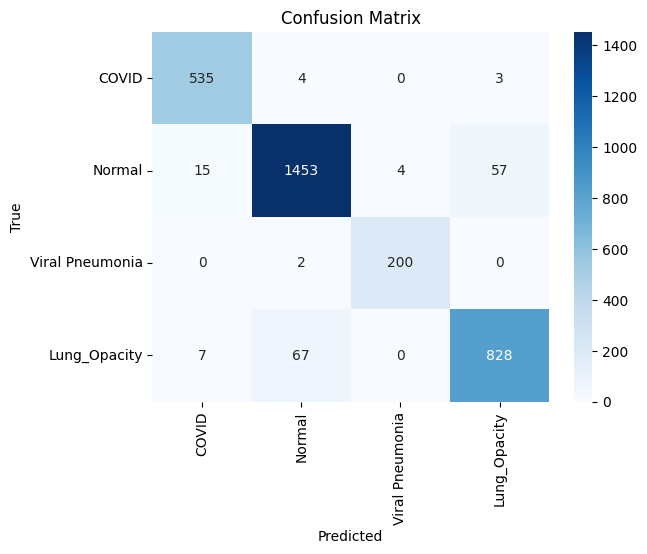

                 precision    recall  f1-score   support

          COVID       0.96      0.99      0.97       542
         Normal       0.95      0.95      0.95      1529
Viral Pneumonia       0.98      0.99      0.99       202
   Lung_Opacity       0.93      0.92      0.93       902

       accuracy                           0.95      3175
      macro avg       0.96      0.96      0.96      3175
   weighted avg       0.95      0.95      0.95      3175



In [11]:
model.load_state_dict(torch.load("best_densenet121_4class.pth"))
model.eval()

y_true,y_pred=[],[]
with torch.no_grad():
    for imgs,labels in val_loader:
        imgs,labels=imgs.to(device),labels.to(device)
        out=model(imgs)
        _,preds=torch.max(out,1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

labels_idx=[0,1,2,3]
cm=confusion_matrix(y_true,y_pred,labels=labels_idx)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
            xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted");plt.ylabel("True");plt.title("Confusion Matrix");plt.show()
print(classification_report(y_true,y_pred,labels=labels_idx,target_names=classes,zero_division=0))